# graph_response_time_data

Display response time data collected by `monitor_response_times_v2.py`

In [25]:
from typing import Any

import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

In [26]:
MONITORING_DATA_TIMESTAMP = "20220310_112950"
MONITORING_DATA_DIR = f"../monitoring_data_{MONITORING_DATA_TIMESTAMP}"

In [27]:
class ResponseTimeDisplayMethods:
    def __init__(self, input_filename: str,
                 graph_title: str,
                 timestamp_columnname: str,
                 response_duration_columnname: str,
                 response_code_columnname: str,
                 response_reason_columnname: str,
                 is_subplot: bool = False,
                 figure_width: float = 10,
                 figure_height: float = 6.18):
        self.input_filename = input_filename
        self.graph_title = graph_title
        self.timestamp_columnname = timestamp_columnname
        self.response_duration_columnname = response_duration_columnname
        self.response_code_columnname = response_code_columnname
        self.response_reason_columnname = response_reason_columnname
        self.is_subplot = is_subplot
        self.figure_width = figure_width
        self.figure_height = figure_height
        plt.style.use("fast")

    def load_file_to_df(self, sep: str = ',') -> pd.DataFrame:
        return pd.read_csv(self.input_filename, sep=sep)

    def clean_up_data(self, df: pd.DataFrame) -> pd.DataFrame:
        # Extract the columns of interest from any others that may be present
        keep_columns = [self.timestamp_columnname, self.response_duration_columnname,
                       self.response_code_columnname, self.response_reason_columnname]
        df = df[keep_columns]

        # Remove any rows that are completely empty
        df = df.dropna(how='all') # Removes all rows that are completely empty

        # Sort by the timestamp column
        df = df.sort_values(by=[self.timestamp_columnname])

        return df

    def update_timestamp_colum(self, df: pd.DataFrame) -> pd.DataFrame:
        df[self.timestamp_columnname] = pd.to_datetime(df[self.timestamp_columnname])
        df.set_index(self.timestamp_columnname)

        # Set the timestamp column as the first column
        cols = list(df)
        cols.insert(0, cols.pop(cols.index(self.timestamp_columnname)))
        df = df.loc[:, cols]
        return df

    def format_x_axis_time(self) -> None:
        ax = plt.gca() # Get current axes
        ax.xaxis.set_major_locator(mdates.HourLocator())
        ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=range(0, 59, 5)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d %H:%M'))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
        for label in ax.get_xticklabels(which='major'):
            label.set(rotation=90, horizontalalignment='right')
        for label in ax.get_xticklabels(which='minor'):
            label.set(rotation=90, horizontalalignment='right')

    def add_legend(self) -> None:
        ax = plt.gca() # Get current axes
        ax.legend(loc='upper left', frameon=True, edgecolor="b")

    def draw_line_graph(self, df: pd.DataFrame) -> None:
        df[self.timestamp_columnname] = pd.to_datetime(df[self.timestamp_columnname])
        df.set_index(self.timestamp_columnname)

        # plt.style.use("fast")
        # figure = plt.figure(figsize=(12, 10))
        plt.xlabel("Time (UTC)")
        self.format_x_axis_time()
        plt.ylabel("Response Time (seconds)")
        plt.title(self.graph_title)
        plt.plot(df[self.timestamp_columnname], df[self.response_duration_columnname], linestyle="-", color="b")

    def add_markers(self, df: pd.DataFrame,
                    value_columnname: str, match_value: Any,
                    marker: str, marker_color: str,
                    label: str) -> None:
        df_matches = df[df[value_columnname] == match_value]
        if df_matches.shape[0] == 0: # No matching rows
            return
        x_axis_match_timestamps = df_matches[self.timestamp_columnname]
        y_axis_match_response_duration = df_matches[self.response_duration_columnname]

        plt.scatter(x_axis_match_timestamps, y_axis_match_response_duration,
                    marker=marker, c=marker_color, label=label)

    def draw_success_markers(self, df: pd.DataFrame) -> None:
        self.add_markers(df, self.response_reason_columnname, "OK",
                         marker='o', marker_color='g', label="Success (2xx)")

    def draw_error_markers(self, df):
        # For colors available, see: https://matplotlib.org/stable/gallery/color/named_colors.html
        for status_code, color in (401, "k"), (500, "r"), (502, mcolors.TABLEAU_COLORS['tab:orange']):
            self.add_markers(df, self.response_code_columnname, status_code,
                             marker='v', marker_color=color, label=f"Error ({status_code})")

    def draw_line_graph_with_error_markers(self, df: pd.DataFrame) -> None:
        self.draw_line_graph(df)
        self.draw_success_markers(df)
        self.draw_error_markers(df)
        self.add_legend()
        # plt.show()

    def display_statistics(self, df: pd.DataFrame) -> None:
        print(f"Maximum value:\t{round(df[self.response_duration_columnname].max(), 1)} seconds")
        print(f"Mean value:\t\t{round(df[self.response_duration_columnname].mean(), 1)} seconds")
        print(f"95th quantile:\t{round(df[self.response_duration_columnname].quantile(0.95), 1)} seconds")

    def display_response_times(self) -> None:
        print(self.graph_title)
        df = self.load_file_to_df()
        df = self.clean_up_data(df)
        df = self.update_timestamp_colum(df)
        self.display_statistics(df)
        if not self.is_subplot:
            plt.figure(1, figsize=(self.figure_width, self.figure_height))
        self.draw_line_graph_with_error_markers(df)

In [28]:
def get_graph_columnname_kwargs(basename: str):
    return dict(timestamp_columnname=f"{basename}.start_time",
                response_duration_columnname=f"{basename}.response_duration",
                response_code_columnname=f"{basename}.response_code",
                response_reason_columnname=f"{basename}.response_reason")

In [29]:
def display_martha_response_times(input_filename: str, is_subplot: bool = False) -> None:
    graph_title = "Martha Response Time"
    displayer = ResponseTimeDisplayMethods(input_filename, graph_title,
                                           **get_graph_columnname_kwargs("martha"),
                                           is_subplot=is_subplot)
    displayer.display_response_times()

In [30]:
def display_fence_user_info_response_times(input_filename: str, is_subplot: bool = False) -> None:
    graph_title = "Fence User Info Response Time"
    displayer = ResponseTimeDisplayMethods(input_filename, graph_title,
                                           **get_graph_columnname_kwargs("fence_user_info"),
                                           is_subplot=is_subplot)
    displayer.display_response_times()

In [31]:
def display_bond_get_link_url_response_times(input_filename: str, is_subplot: bool = False) -> None:
    graph_title = "Bond Get Link URL Response Time"
    displayer = ResponseTimeDisplayMethods(input_filename, graph_title,
                                           **get_graph_columnname_kwargs("bond_get_link_url"),
                                           is_subplot=is_subplot)
    displayer.display_response_times()

In [32]:
def display_bond_get_link_status_response_times(input_filename: str, is_subplot: bool = False) -> None:
    graph_title = "Bond Get Link Status Response Time"
    displayer = ResponseTimeDisplayMethods(input_filename, graph_title,
                                           **get_graph_columnname_kwargs("bond_get_link_status"),
                                           is_subplot=is_subplot)
    displayer.display_response_times()

In [33]:
def display_indexd_get_metadata_response_times(input_filename: str, is_subplot: bool = False) -> None:
    graph_title = "Gen3 IndexD Get DRS Metadata Response Time"
    displayer = ResponseTimeDisplayMethods(input_filename, graph_title,
                                           **get_graph_columnname_kwargs("indexd_get_metadata"),
                                           is_subplot=is_subplot)
    displayer.display_response_times()

In [34]:
def display_bond_get_access_token_response_times(input_filename: str, is_subplot: bool = False) -> None:
    graph_title = "Bond Get Access Token Response Time"
    displayer = ResponseTimeDisplayMethods(input_filename, graph_title,
                                           **get_graph_columnname_kwargs("bond_get_access_token"),
                                           is_subplot=is_subplot)
    displayer.display_response_times()

In [35]:
def display_bond_get_sa_key_response_times(input_filename: str, is_subplot: bool = False) -> None:
    graph_title = "Bond Get Service Account Key Response Time"
    displayer = ResponseTimeDisplayMethods(input_filename, graph_title,
                                           **get_graph_columnname_kwargs("bond_get_sa_key"),
                                           is_subplot=is_subplot)
    displayer.display_response_times()

In [36]:
def display_fence_get_signed_url_response_times(input_filename: str, is_subplot: bool = False) -> None:
    graph_title = "Gen3 Fence Get Signed URL Response Time"
    displayer = ResponseTimeDisplayMethods(input_filename, graph_title,
                                           **get_graph_columnname_kwargs("fence_get_signed_url"),
                                           is_subplot=is_subplot)
    displayer.display_response_times()

In [37]:
def display_drs_flow_component_response_times(input_filename: str) -> None:
    plt.figure(figsize=(15, 15))
    is_subplot = True

    plt.subplot(2, 2, 1)
    display_indexd_get_metadata_response_times(input_filename, is_subplot)

    plt.subplot(2, 2, 2)
    display_bond_get_access_token_response_times(input_filename, is_subplot)

    plt.subplot(2, 2, 3)
    display_fence_get_signed_url_response_times(input_filename, is_subplot)

    plt.subplot(2, 2, 4)
    display_bond_get_sa_key_response_times(input_filename, is_subplot)

    plt.show()

Gen3 IndexD Get DRS Metadata Response Time
Maximum value:	0.3 seconds
Mean value:		0.2 seconds
95th quantile:	0.2 seconds
Bond Get Access Token Response Time
Maximum value:	115.4 seconds
Mean value:		15.7 seconds
95th quantile:	69.3 seconds
Gen3 Fence Get Signed URL Response Time
Maximum value:	0.3 seconds
Mean value:		0.2 seconds
95th quantile:	0.3 seconds
Bond Get Service Account Key Response Time
Maximum value:	74.9 seconds
Mean value:		7.0 seconds
95th quantile:	24.8 seconds


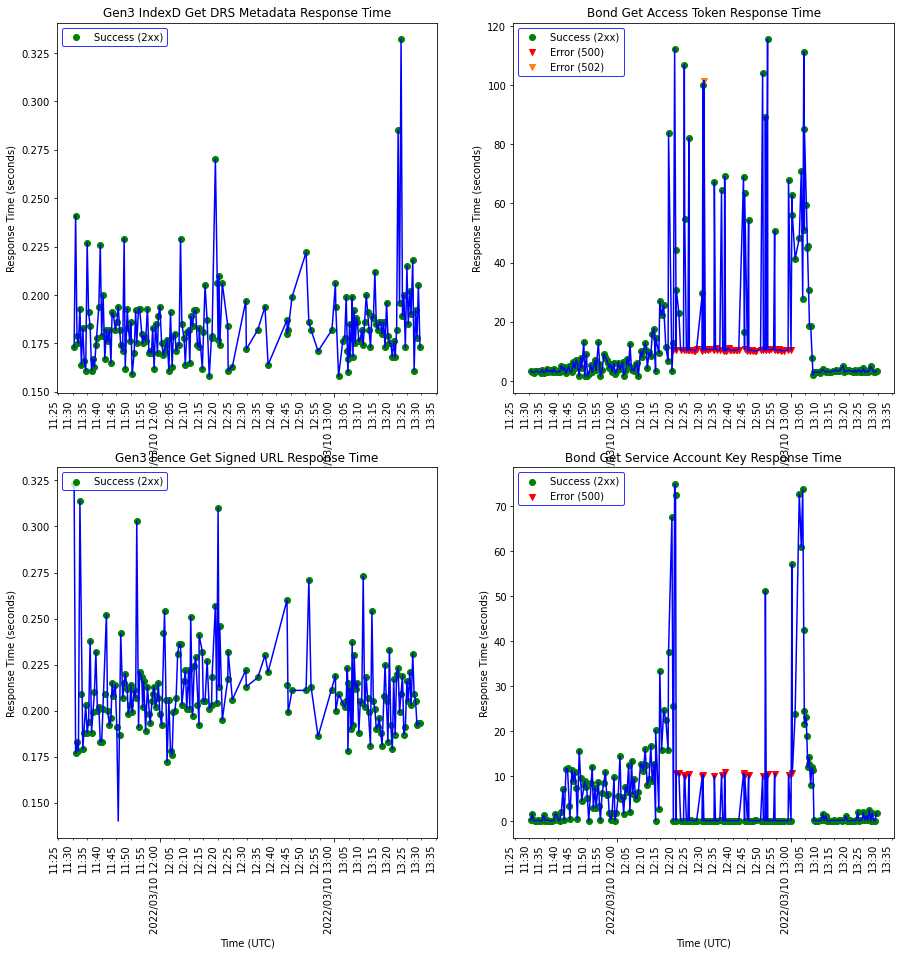

In [38]:
display_drs_flow_component_response_times(
    f"{MONITORING_DATA_DIR}/drs_flow_response_times_{MONITORING_DATA_TIMESTAMP}.csv")

In [39]:
def display_bond_link_info_response_times(input_filename: str) -> None:
    plt.figure(figsize=(15, 7))
    is_subplot = True

    plt.subplot(1, 2, 1)
    display_bond_get_link_url_response_times(input_filename, is_subplot)

    plt.subplot(1, 2, 2)
    display_bond_get_link_status_response_times(input_filename, is_subplot)

    plt.show()

Bond Get Link URL Response Time
Maximum value:	117.1 seconds
Mean value:		12.8 seconds
95th quantile:	57.1 seconds
Bond Get Link Status Response Time
Maximum value:	91.9 seconds
Mean value:		14.0 seconds
95th quantile:	54.4 seconds


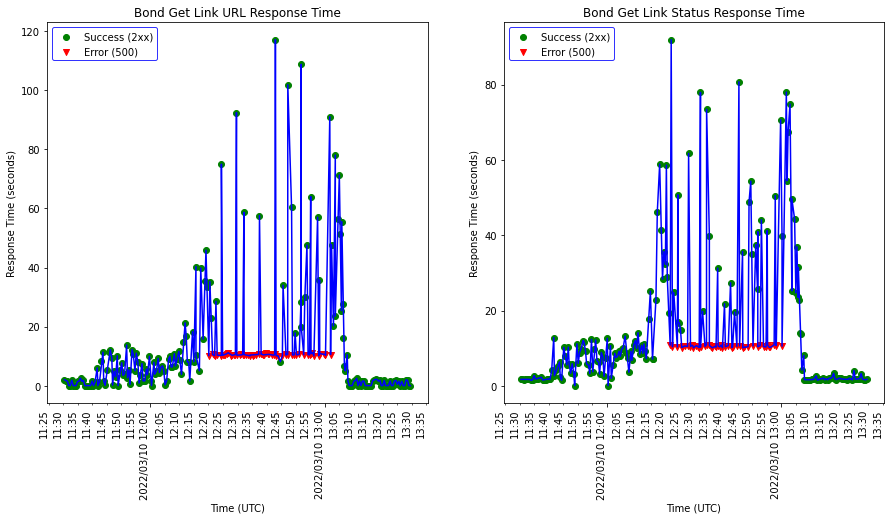

In [40]:
display_bond_link_info_response_times(
    f"{MONITORING_DATA_DIR}/bond_external_idenity_response_times_{MONITORING_DATA_TIMESTAMP}.csv")


Martha Response Time
Maximum value:	58.2 seconds
Mean value:		30.0 seconds
95th quantile:	58.1 seconds


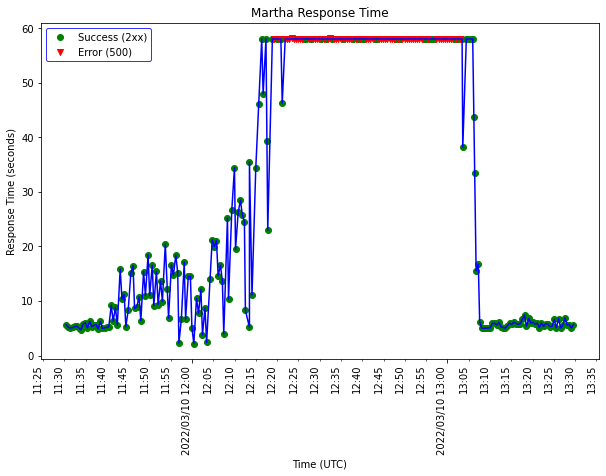

In [41]:
display_martha_response_times(f"{MONITORING_DATA_DIR}/martha_response_time_{MONITORING_DATA_TIMESTAMP}.csv")

Fence User Info Response Time
Maximum value:	36.9 seconds
Mean value:		3.3 seconds
95th quantile:	17.0 seconds


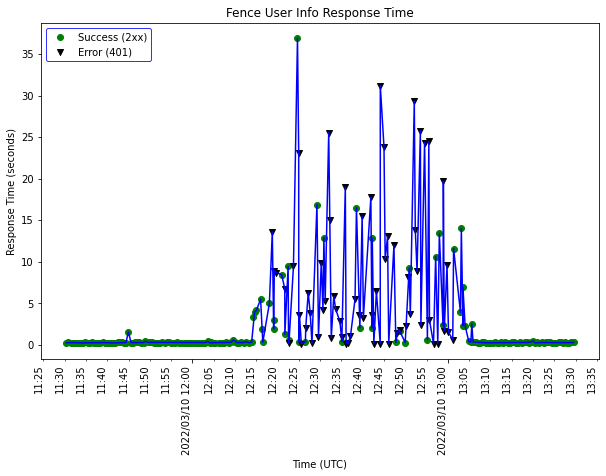

In [42]:
display_fence_user_info_response_times(
    f"{MONITORING_DATA_DIR}/fence_user_info_response_time_{MONITORING_DATA_TIMESTAMP}.csv")

Bond Get Link URL Response Time
Maximum value:	117.1 seconds
Mean value:		12.8 seconds
95th quantile:	57.1 seconds


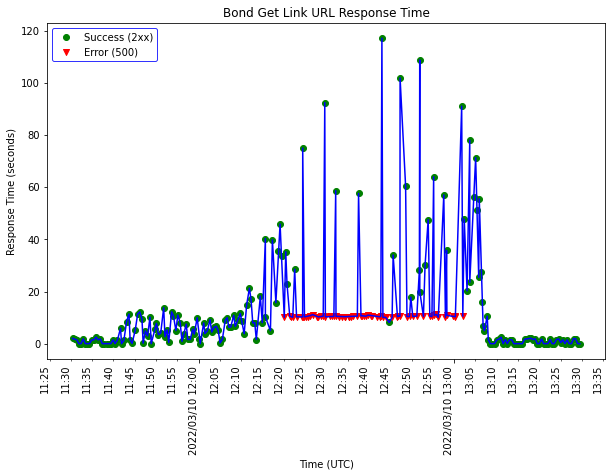

In [43]:
display_bond_get_link_url_response_times(
    f"{MONITORING_DATA_DIR}/bond_external_idenity_response_times_{MONITORING_DATA_TIMESTAMP}.csv")


Bond Get Link Status Response Time
Maximum value:	91.9 seconds
Mean value:		14.0 seconds
95th quantile:	54.4 seconds


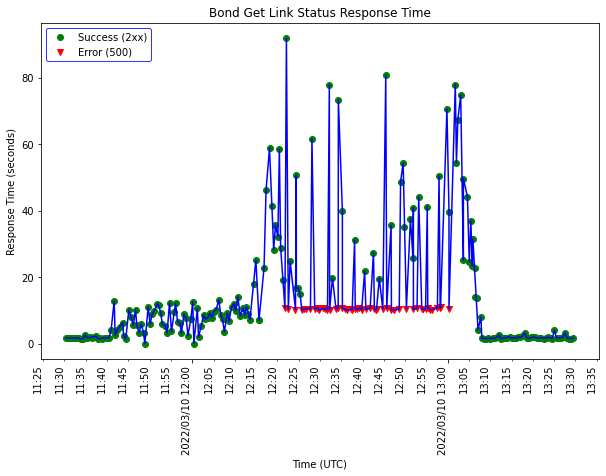

In [44]:
display_bond_get_link_status_response_times(
    f"{MONITORING_DATA_DIR}/bond_external_idenity_response_times_{MONITORING_DATA_TIMESTAMP}.csv")

Gen3 IndexD Get DRS Metadata Response Time
Maximum value:	0.3 seconds
Mean value:		0.2 seconds
95th quantile:	0.2 seconds


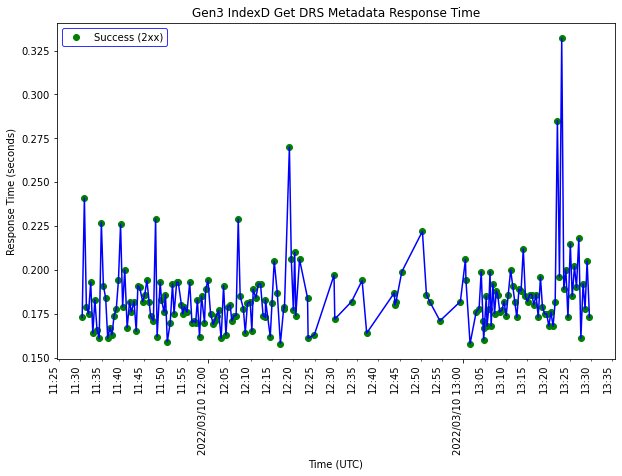

In [45]:
display_indexd_get_metadata_response_times(
    f"{MONITORING_DATA_DIR}/drs_flow_response_times_{MONITORING_DATA_TIMESTAMP}.csv")

Bond Get Access Token Response Time
Maximum value:	115.4 seconds
Mean value:		15.7 seconds
95th quantile:	69.3 seconds


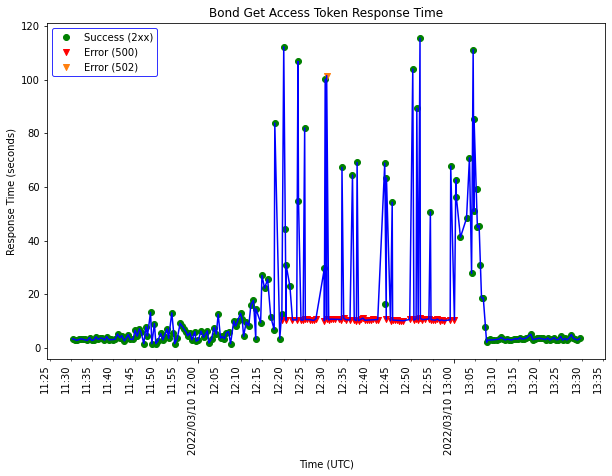

In [46]:
display_bond_get_access_token_response_times(
    f"{MONITORING_DATA_DIR}/drs_flow_response_times_{MONITORING_DATA_TIMESTAMP}.csv")

Bond Get Service Account Key Response Time
Maximum value:	74.9 seconds
Mean value:		7.0 seconds
95th quantile:	24.8 seconds


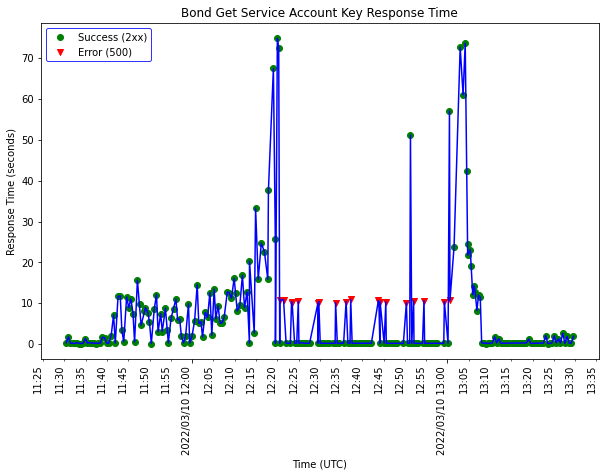

In [47]:
display_bond_get_sa_key_response_times(f"{MONITORING_DATA_DIR}/drs_flow_response_times_{MONITORING_DATA_TIMESTAMP}.csv")

Gen3 Fence Get Signed URL Response Time
Maximum value:	0.3 seconds
Mean value:		0.2 seconds
95th quantile:	0.3 seconds


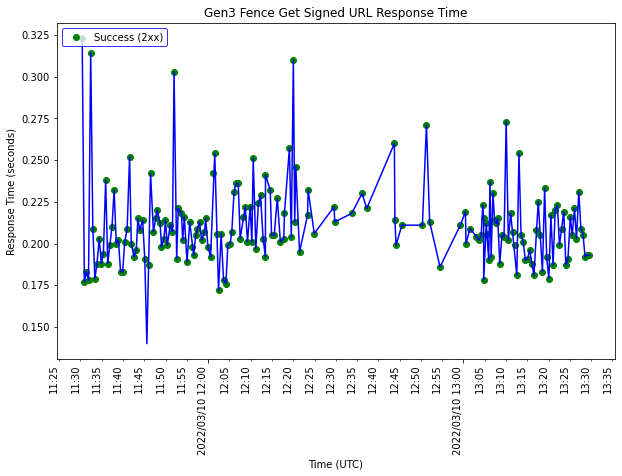

In [48]:
display_fence_get_signed_url_response_times(
    f"{MONITORING_DATA_DIR}/drs_flow_response_times_{MONITORING_DATA_TIMESTAMP}.csv")